In [1]:
import tensorflow as tf
from time import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from local.lib import mlutils
%matplotlib inline

## Imágenes desde ficheros

ref https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

### descargamos imágenes de dos queries en google

In [2]:
!pip install google_images_download

In [3]:
downloads = "/downloads"
traintest_imgs = "/tmp/imgs"

train_pct = .7

In [4]:
!rm -rf $downloads
!mkdir $downloads

cfg="""
{
    "Records": [
        {
            "keywords": "car",
            "format": "jpg",
            "limit": 50,
            "type": "photo",
            "size": "medium",
            "output_directory": "%s"
        },
        {
            "keywords": "truck",
            "format": "jpg",
            "limit": 50,
            "type": "photo",
            "size": "medium", 
            "output_directory": "%s"
        }
    ]
}
"""%(downloads, downloads)

In [5]:
with open(downloads+"/cfg.txt", "w") as f:
    f.write(cfg)

In [6]:
!googleimagesdownload --config_file $downloads/cfg.txt


Item no.: 1 --> Item name = car
Evaluating...
Starting Download...
Completed Image ====> 1.2020-cars.jpg
Completed Image ====> 2.car-of-the-year-2020-nominados.jpg
Completed Image ====> 3.apple-car-3-970x647-c-3-720x480.jpg
Completed Image ====> 4.k8519lf8_bugatti-centodieci-unveiled-at-pebble-beach-car-show_625x300_17_August_19.jpg
Completed Image ====> 5.190904112438-porsche-taycan-turbo-s-exlarge-169.jpg
Completed Image ====> 6._105855160_c_two-studio-image-front.jpg
Completed Image ====> 7.300x600_hackercar_octubre_KADJAR.jpg
Completed Image ====> 8.EVO%20SPYDER%20MOBILE.jpg
Completed Image ====> 9.Fastest-autonomous-car-header_tcm25-595278.jpg
Completed Image ====> 10.34574_1.jpg
Completed Image ====> 11.hqdefault.jpg
Completed Image ====> 12.637873-tesla-model-s-2019-640x360.jpg
Completed Image ====> 13._109734326_bf719441-85d2-4e17-89d1-90f62e4028aa.jpg
Completed Image ====> 14.Excellent-Best-Used-Sports-Car-2019-19-For-best-sports-saloon-car-2019-for-Best-Used-Sports-Car-2019.

### revisamos las imágenes y eliminamos las defectuosas

In [10]:
from skimage import io
files = !find $downloads -type f
for fname in files:
    if fname!=downloads+"/cfg.txt":
        print (".", end="")
        try:
            io.imread(fname)
        except:
            print ("\nremoving",fname,"as cannot be read\n")
            !rm $fname

...................
removing /tmp/downloads/car/8.EVO%20SPYDER%20MOBILE.jpg as cannot be read

.......
removing /tmp/downloads/car/30.Lam1_trans_NvBQzQNjv4BqnAdySV0BR-4fDN_-_p756cVfcy8zLGPV4EhRkjQy7tg.jpg as cannot be read

......................................
removing /tmp/downloads/truck/44.2020-sierra-1500-satin-steel-metallic-update.jpg as cannot be read

....................................


### organizamos las imágenes en train y en test

In [11]:
classdirs = !find $downloads -type d
classdirs = [i.split("/")[-1] for i in classdirs if i!=downloads]
print (classdirs)

['car', 'truck']


In [12]:
!rm -rf $traintest_imgs

In [13]:
for classdir in classdirs:
    print (classdir)
    print ("    splitting files ... ", end=" ")
    files = !find $downloads/$classdir -type f
    files = np.r_[files]
    n_train = int(len(files)*train_pct)
    files = np.random.permutation(files)
    files_train = files[:n_train]
    files_test  = files[n_train:]
    !mkdir -p $traintest_imgs/train/$classdir
    !mkdir -p $traintest_imgs/test/$classdir
    print ("copying files")
    for f in files_train:
        !cp $f $traintest_imgs/train/$classdir
    for f in files_test:
        !cp $f $traintest_imgs/test/$classdir

car
    splitting files ...  copying files
truck
    splitting files ...  copying files


### sanity check 1

In [14]:
for classdir in classdirs:
    print (classdir)
    files = !find  $traintest_imgs/train/$classdir -type f
    print ("      ",len(files), "train images")
    files = !find  $traintest_imgs/test/$classdir -type f
    print ("      ",len(files), "test images")

car
       33 train images
       15 test images
truck
       34 train images
       15 test images


### sanity check 2

see [ImageGenerator](https://keras.io/preprocessing/image/)

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [16]:
datagen = ImageDataGenerator(rescale=1./255, fill_mode='nearest')
batch_size = 10
img_size = 32
train_generator_fn = lambda: datagen.flow_from_directory(
        traintest_imgs+"/train",  # this is the target directory
        target_size=(img_size, img_size),  # all images will be resized to 150x150
        batch_size=batch_size,
        interpolation = "bilinear",
        class_mode='binary') 

test_generator_fn = lambda: datagen.flow_from_directory(
        traintest_imgs+"/test",  # this is the target directory
        target_size=(img_size, img_size),  # all images will be resized to 150x150
        batch_size=batch_size,
        interpolation = "bilinear",
        class_mode='binary') 

Found 67 images belonging to 2 classes.


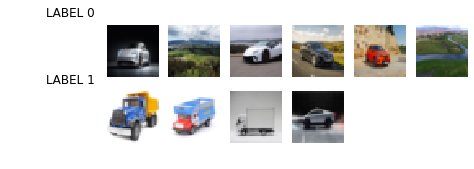

In [17]:
for imgs,labels in train_generator_fn():
    if np.random.random()>.5:
        break
mlutils.show_labeled_image_mosaic(imgs, labels)

### train keras!!!

In [19]:
def get_conv_model_A(num_classes, img_size=32, compile=True):
    tf.reset_default_graph()
    tf.keras.backend.clear_session()
    print ("using",num_classes,"classes")
    inputs = tf.keras.Input(shape=(img_size,img_size,3), name="input_1")
    layers = tf.keras.layers.Conv2D(15,(10,10), activation="relu")(inputs)
    layers = tf.keras.layers.Flatten()(layers)
    layers = tf.keras.layers.Dense(64, activation=tf.nn.relu)(layers)
    layers = tf.keras.layers.Dropout(0.2)(layers)
    predictions = tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax, name="output_1")(layers)
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    if compile:
        model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    return model

In [20]:
num_classes = len(classdirs)
model = get_conv_model_A(num_classes, img_size=img_size)

model.fit_generator(
        train_generator_fn(),
        steps_per_epoch=1000 // batch_size,
        epochs=3,
        validation_data=test_generator_fn(),
        validation_steps=400 // batch_size)


using 2 classes
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Found 67 images belonging to 2 classes.
Found 30 images belonging to 2 classes.
Epoch 1/3
7/7 [==============================] - 1s 199ms/step - loss: 1.0313 - acc: 0.3881 - val_loss: 0.6927 - val_acc: 0.5000
Epoch 2/3
7/7 [==============================] - 1s 172ms/step - loss: 0.6937 - acc: 0.5075 - val_loss: 0.6989 - val_acc: 0.4667
Epoch 3/3
7/7 [==============================] - 1s 173ms/step - loss: 0.6735 - acc: 0.6866 - val_loss: 0.7456 - val_acc: 0.4667


### predictions

In [21]:
def show_preds(x, preds):
    for i  in np.random.permutation(range(len(preds)))[:4]:
        plt.figure(figsize=(5,2.5))
        plt.subplot(122)
        plt.imshow(x[i])
        plt.axis("off")
        plt.subplot(121)
        plt.bar(np.arange(2), preds[i], color="blue", alpha=.5, label="prediction")
        plt.bar(np.arange(2), np.eye(2,2)[int(y[i])], color="red", alpha=.5, label="label")
        plt.xticks(range(2), range(2), rotation="vertical");
        plt.xlim(-.5,1.5);
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, +1.35),ncol=5)


In [48]:
from importlib import reload
reload(mlutils)

<module 'local.lib.mlutils' from '/home/user/share/Dropbox/teaching/machine-learning/DiplomadoEPM_2019/Modulo2/local/lib/mlutils.py'>

Found 30 images belonging to 2 classes.


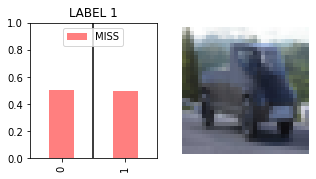

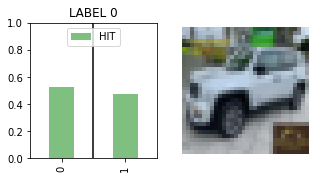

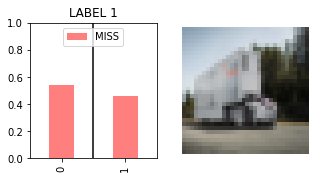

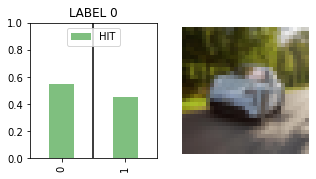

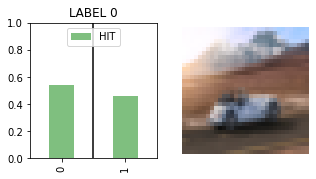

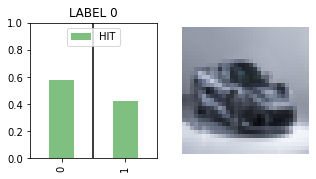

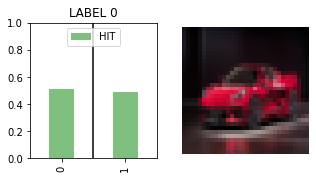

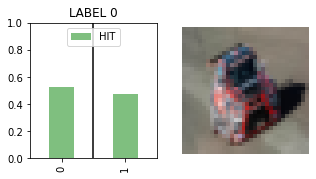

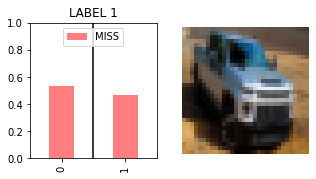

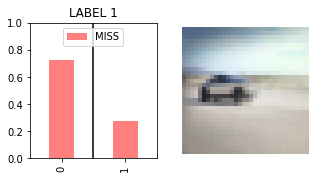

In [49]:
for x,y in test_generator_fn():
    if np.random.random()>.7:
        break
        
preds = model.predict(x)
mlutils.show_preds(x, y, preds)